# Traffic Sign Recognition with Convolutional Neural Networks

## Capstone Project 

## Machine Learning Engineer Nanodegree

### Domain Background
Autonomous driving is one of the main research areas of artificial intelligence and machine learning.
Traffic sign recognition has been available in advanced driver assistance systems since 2008
(https://en.wikipedia.org/wiki/Traffic-sign_recognition). Although research has been done for
many years in this domain, there are still unsolved problems, such as computer vision in bad
weather conditions, at nighttime, or additional traffic signs that are difficult to classify. 

### Problem Statement
In my capstone project of Udacity's Machine Learning Engineer Nanodegree I want to implement a traffic sign detector. The detector should get images
of traffic signs of different classes as input and return the most likely class as output. 


---
## 1. Data Exploration

### Datasets and Inputs
In order to achieve this goal, I want to use the Belgian Traffic Sign Recognition Benchmark (https://btsd.ethz.ch/shareddata/). The training and testing sets can be found here: https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Training.zip and https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Testing.zip, respectively. 

The Belgian Traffic Sign Recognition Benchmark is a multi-class, single-image classification challenge. It contains images from 62 classes in total and is a large, lifelike database. The images are taken in different angles and lighting conditions. Therefore, the use of this dataset is appropriate given the context of the problem.

### Data Exploration and Pre-Processing

First, I will load the data and explore the given images. I will write some basic
code to see how the images look like, how the data is organized and decide which modifications
have to be done. I will also perform a split into training, validation and testing data. Further, the image data should be normalized so that the data has mean zero and equal variance. I will use data augmentation techniques as well.


In [2]:
# Colab settings
from google.colab import drive
drive.mount('/content/drive/')
!cd '/content/drive/My Drive/app/' 

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
# download the required data files
!rm -r Training || true
!rm -r Testing || true
!wget -cq https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Training.zip
!wget -cq https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Testing.zip

!unzip -qq BelgiumTSC_Training.zip
!unzip -qq BelgiumTSC_Testing.zip


In [0]:
train_dir = 'Training'
test_dir = 'Testing'

In [0]:
# imports
import torch
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from PIL import Image 
from torch import nn, optim
import torch.nn.functional as F
import numpy as np
import os, random

In [0]:
def calc_stats(data_dir):
    # calc mean and standard deviation for normalization

    data = datasets.ImageFolder(data_dir, transform=transforms.ToTensor())
    dataloader = torch.utils.data.DataLoader(data, batch_size=1)
    total_mean =[0, 0, 0]
    total_std =[0, 0, 0]
    for image, label in dataloader:
        np_image = image.numpy()
        # print(np_image.shape) # shape is (batch_size, 3, height, width) = (1, 3, 224, 224)
        mean = np.mean(np_image, axis=(0,2,3)) # normalize each color channel separately
        # alternative
        # mean_red = np.mean(np_image[:,0,:,:])
        # mean_green = np.mean(np_image[:,1,:,:])
        # mean_blue = np.mean(np_image[:,2,:,:])
        total_mean += mean
        std = np.std(np_image, axis=(0,2,3))
        total_std += std

    total_mean /= len(dataloader)
    total_std /= len(dataloader)
    return total_mean, total_std

In [7]:
mean_train, std_train = calc_stats(train_dir)
print("Image mean for training data is ", mean_train)
print("Image standard deviation for training data is ", std_train)
mean_test, std_test = calc_stats(test_dir)
print("Image mean for test data is ", mean_test)
print("Image standard deviation for test data is ", std_test)

Image mean for training data is  [0.40136005 0.376268   0.38119228]
Image standard deviation for training data is  [0.21011613 0.22781859 0.23043948]
Image mean for test data is  [0.40314721 0.36578301 0.36349471]
Image standard deviation for test data is  [0.20310657 0.22656579 0.22864133]


In [0]:
# transforms for the training and validation sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                    transforms.RandomResizedCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean_train, std_train)])
test_transforms = transforms.Compose([transforms.Resize(255), 
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean_test, std_test)])

# load the datasets with ImageFolder
train_data_full = datasets.ImageFolder(train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

# split training data further into training and validation data
train_size = int(0.8 * len(train_data_full))
valid_size = len(train_data_full) - train_size
train_data, valid_data = torch.utils.data.random_split(train_data_full, [train_size, valid_size])


# using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=16, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)

In [9]:
print('Size of training plus validation dataset: ', len(train_data_full))
print('Size of training dataset: ', train_size)
print('Size of validation dataset: ', valid_size)
print('Size of test dataset: ', len(testloader))

Size of training plus validation dataset:  4575
Size of training dataset:  3660
Size of validation dataset:  915
Size of test dataset:  2520


### Visualization of the dataset

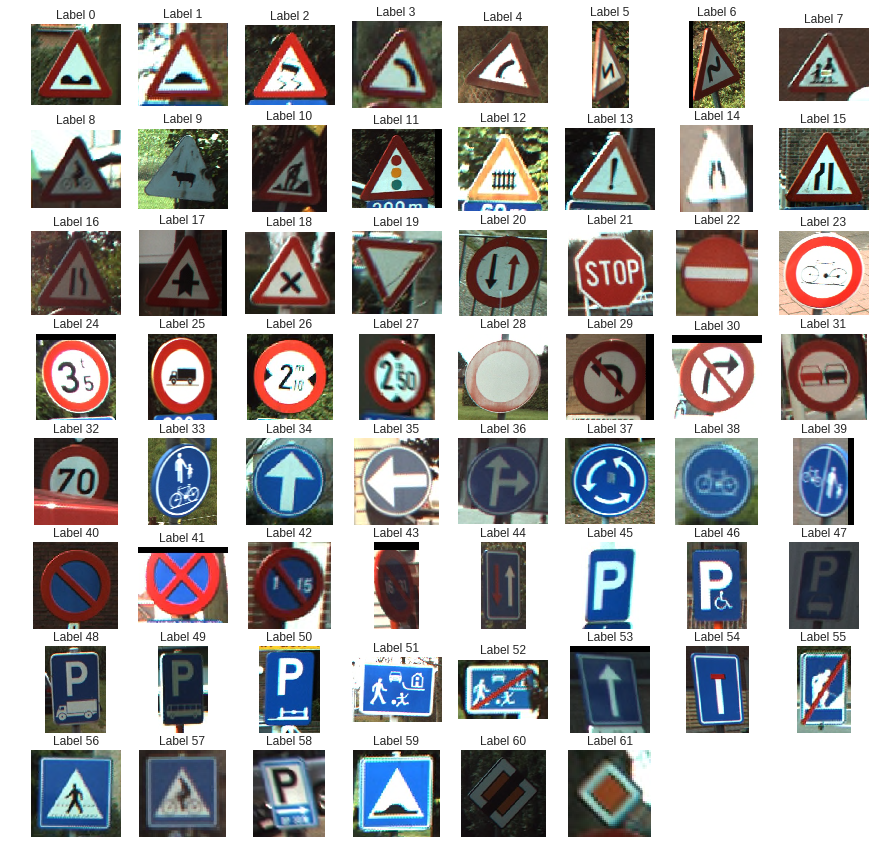

In [10]:
# visualizations will be shown in the notebook.
%matplotlib inline

plt.figure(figsize=(15, 15))
for i in range(62):
    # go through each data folder
    folder = '000' + str(i)
    if i<10:
        folder = '0' + folder
    whole_path = train_dir + '/' + folder
    
    # take random image sample from each folder
    while True:
        file_name = random.sample(os.listdir(whole_path), 1)[0]
        if file_name.endswith(".ppm"):
            break
    whole_path += '/' + file_name
    
    # plot random image
    plt.subplot(8, 8, i+1)  
    plt.axis('off')
    img = Image.open(whole_path)
    plt.imshow(img)
    plt.title("Label {0}".format(i))
plt.show()


----

## 2. Implementation of a Model Architecture


### Solution Statement
In order to solve this classification problem, I want to use a Convolutional Neural Network (CNN).
The CNN should get an image as input and give the probabilities of the classes as output. I
will design a CNN from scratch in PyTorch rather than use transfer learning because I want to
understand the neural net’s behavior in detail.

### Benchmark Model
The paper "Traffic Sign Recognition – How far are we from the solution?" by Markus Mathias, Radu Timofte, Rodrigo Benenson, and Luc Van Gool can serve as a benchmark for this problem. It was published at the International Joint Conference on Neural Networks (IJCNN 2013), Dallas, USA, and can be found here: https://btsd.ethz.ch/shareddata/publications/Mathias-IJCNN-2013.pdf. Authors report that their models reached an accuracy between 95% and 99% without including traffic sign specific knowledge in the classifiers. 

### Model Architecture

In [0]:
# model architecture

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1, stride=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=2)
        
        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 3, padding=1, stride = 2):
            return (size - kernel_size + 2*padding) // stride  + 1
        image_width_conv = int(conv2d_size_out(conv2d_size_out(224)/2)/2)
        linear_input_size = image_width_conv * image_width_conv * 32 # 32 = number of output channels in last conv layer
        self.lin = nn.Linear(linear_input_size, 62) # 62 = number of classes
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
        self.optimizer = optim.Adam(self.parameters(), lr=0.0001)
        self.criterion = nn.NLLLoss()

    # Called with either one element to determine next action, or a batch
    # during optimization.
    def forward(self, x):
        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool(self.conv2(x)))
        return self.logsoftmax(self.lin(x.view(x.size(0), -1)))

## 3. Training 

When the model architecture is defined, the model has to be trained. I will use Google
Colab in order to accelerate training with GPU support. During training, I will monitor train and
test losses to avoid overfitting. I will also evaluate accuracy improvement during training on a
validation set.

In [0]:
model = Net()
total_acc = 0

In [19]:
# training

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device =',device)
model.to(device)

num_episodes = 20

steps = 0
running_loss = 0
print_every = 100 #np.inf
for i_episode in range(num_episodes):
    for inputs, labels in trainloader:
        steps += 1
        
        # Move input and label tensors to the default device
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        model.optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = model.criterion(logps, labels)
        loss.backward()
        model.optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0 or i == len(trainloader)-1:
            valid_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in validloader:

                    # Move input and label tensors to the default device
                    inputs = inputs.to(device)
                    labels = labels.to(device)
        
                    logps = model.forward(inputs)
                    batch_loss = model.criterion(logps, labels)
                    valid_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            accuracy /= len(validloader)
            valid_loss /= len(validloader)
            print(f"Epoch {i_episode+1}/{num_episodes}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Valid loss: {valid_loss:.3f}.. "
                  f"Valid accuracy: {accuracy:.3f}")
            running_loss = 0
            model.train()
            if accuracy > total_acc:
                total_acc = accuracy
                print("Accuracy improved! Saving model...")

                # save the checkpoint 
                model.to('cpu') 
                checkpoint = {'opt_state': model.optimizer.state_dict,
                              'class_to_idx': train_data_full.class_to_idx,
                              'total_acc': total_acc,
                              'state_dict': model.state_dict()}
                torch.save(checkpoint, '/content/drive/My Drive/app/traffic_sign_checkpoint.pth')
                model.to(device) 
            else: 
                print("Accuracy not improved. Continuing without saving model...")
            print(f"Last accuracy: {accuracy:.3f}")
            print(f"Best accuracy: {total_acc:.3f}\n")
    
model.to('cpu')

device = cuda:0
Epoch 1/20.. Train loss: 0.947.. Valid loss: 1.155.. Valid accuracy: 0.689
Accuracy not improved. Continuing without saving model...
Last accuracy: 0.689
Best accuracy: 0.708

Epoch 1/20.. Train loss: 1.010.. Valid loss: 1.163.. Valid accuracy: 0.689
Accuracy not improved. Continuing without saving model...
Last accuracy: 0.689
Best accuracy: 0.708

Epoch 2/20.. Train loss: 1.001.. Valid loss: 1.306.. Valid accuracy: 0.659
Accuracy not improved. Continuing without saving model...
Last accuracy: 0.659
Best accuracy: 0.708

Epoch 2/20.. Train loss: 0.943.. Valid loss: 1.166.. Valid accuracy: 0.703
Accuracy not improved. Continuing without saving model...
Last accuracy: 0.703
Best accuracy: 0.708

Epoch 3/20.. Train loss: 1.024.. Valid loss: 1.133.. Valid accuracy: 0.680
Accuracy not improved. Continuing without saving model...
Last accuracy: 0.680
Best accuracy: 0.708

Epoch 3/20.. Train loss: 0.934.. Valid loss: 1.234.. Valid accuracy: 0.670
Accuracy not improved. Contin

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (lin): Linear(in_features=6272, out_features=62, bias=True)
  (logsoftmax): LogSoftmax()
  (criterion): NLLLoss()
)

In [0]:
# function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    
    model = Net()    

    model.load_state_dict(checkpoint['state_dict'], strict=False)
    total_acc = checkpoint['total_acc']
    class_to_idx = checkpoint['class_to_idx']
    
    return model, total_acc, class_to_idx

In [0]:
model, total_acc, class_to_idx = load_checkpoint('/content/drive/My Drive/app/traffic_sign_checkpoint.pth')

# change learnrate for next epochs
model.optimizer = optim.Adam(model.parameters(), lr=0.00001)

## 4. Testing and Evaluation 

Finally, I will test the performance of the trained classifier on the test set.

In [0]:
# function to plot an image from dataloader
def show_image(img):
    img = img.numpy()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    img = np.transpose(img, (1, 2, 0))
    
    # undo preprocessing
    mean = np.array(mean_train)
    std = np.array(std_train)
    img = std*img + mean    
    
    # image needs to be clipped between 0 and 1
    img = np.clip(img, 0, 1)
    
    plt.imshow(img)
    plt.show()

Predicted class:  32 (with probability 1.0)
True class:  32


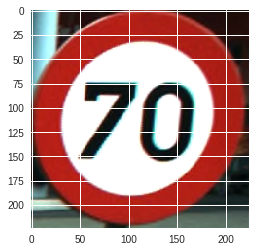

Predicted class:  38 (with probability 0.6)
True class:  38


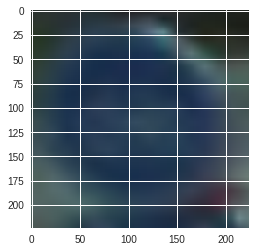

Predicted class:  32 (with probability 1.0)
True class:  32


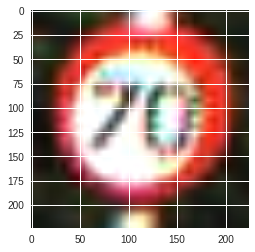

Predicted class:  39 (with probability 0.7)
True class:  39


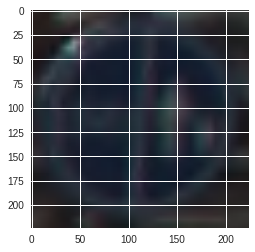

Predicted class:  17 (with probability 0.6)
True class:  17


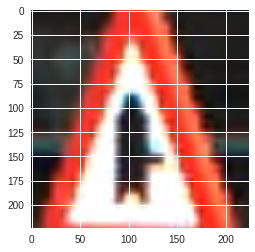

Predicted class:  18 (with probability 0.7)
True class:  18


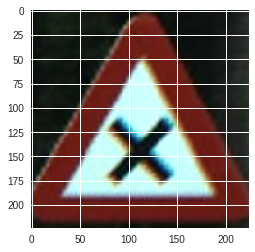

Predicted class:  32 (with probability 0.9)
True class:  32


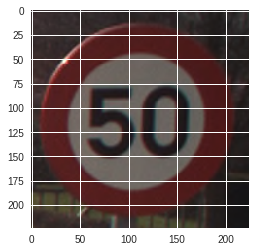

Predicted class:  21 (with probability 0.6)
True class:  21


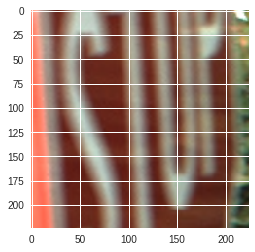

Predicted class:  45 (with probability 0.5)
True class:  45


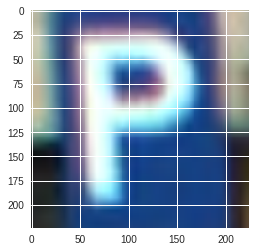

Predicted class:  40 (with probability 0.9)
True class:  40


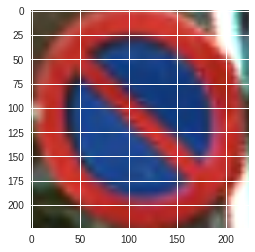

In [23]:
for i in range(10):
    dataiter = iter(testloader)
    image, label = dataiter.next()

    outputs = model.forward(image)
    max_pred, class_pred = torch.max(outputs, 1)
    prob = torch.exp(max_pred)
    print("Predicted class: ", class_pred.item(), "(with probability %1.1f)" % prob.item())
    print("True class: ", label.item())

    show_image(torchvision.utils.make_grid(image))

In [22]:
# final evaluation on test data
accuracy = 0
model.eval()
with torch.no_grad():
    for inputs, labels in testloader:

        logps = model.forward(inputs)

        # calculate accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

accuracy /= len(testloader)
print(f"Final accuracy on test dataset: {accuracy:.3f}")

Final accuracy on test dataset: 0.827


## Conclusion

My traffic sign detector classified signs of the test set with an accuracy of 83%. The benchmark publication reports an accuracy between 95% and 99% (https://btsd.ethz.ch/shareddata/publications/Mathias-IJCNN-2013.pdf). Therefore, there is still room for improvement. However, I used a very small CNN because I wanted to understand the net's structure and setup rather than get a score as high as possible. The performance could of course be improved using transfer learning instead of building a neural net from scratch. Also, I used a simple architecture with only two convolutional layers, two pooling layers and a linear layer. Using more layers could improve the results as well as using dropout to avoid overfitting. 